## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction


For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure I get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  
a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape
print("There are {} rows in the dataset.".format(df.shape[0]))

There are 294478 rows in the dataset.


c. The number of unique users in the dataset.

In [4]:
df.nunique()
print("There are {} unique users in the dataset.".format(df.nunique().user_id))

There are 290584 unique users in the dataset.


d. The proportion of users converted.

In [5]:
pro_userconverted = df.query('converted == 1').user_id.nunique()/(df['user_id'].nunique())
print("The proportion of user converted is {}.".format('%.4f' % pro_userconverted))

The proportion of user converted is 0.1210.


e. The number of times the `new_page` and `treatment` don't match.

In [6]:
notmatch = df[(df['group'] == 'treatment') != (df['landing_page'] == 'new_page')].shape[0]
print("There are {} of times the new page and treatment don't match.".format(notmatch))

There are 3893 of times the new page and treatment don't match.


f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


There are no missing values in the dataset.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  

a. Now reate a new dataset.  Store the new dataframe in **df2**.

In [8]:
df2 = df[(df['group'] == 'treatment') == (df['landing_page'] == 'new_page')]

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[(df2['group'] == 'treatment') != (df2['landing_page'] == 'new_page')].shape[0]

0

`3.` Use **df2** and the cells below to answer questions below.

a. How many unique **user_id**s are in **df2**?

In [10]:
unique_id = df2.nunique().user_id
print("There are {} unique user ids in df2.".format(unique_id))

There are 290584 unique user ids in df2.


b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
rownumber = df2[df2.user_id.duplicated()==True].index[0]
print("The repeat user_id is in {}-th row.".format(rownumber))

The repeat user_id is in 2893-th row.


d. Remove **one** of the rows with a duplicate **user_id**, but keep dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates('user_id')

`4.` Use **df2** in the cells below to answer the quiz questions below.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
p1 = df2.converted.sum()/df2.converted.count()
print("The propability of an individual convert regardless receiving page is {}.".format('%.4f' % p1))

The propability of an individual convert regardless receiving page is 0.1196.


b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
obs_old = len(df2.query("group == 'control' and converted == 1"))/sum(df2['group'] == 'control')
print("The propability of coversion rate in control group is {}.".format('%.4f' % obs_old))

The propability of coversion rate in control group is 0.1204.


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
obs_new = len(df2.query("group == 'treatment' and converted == 1"))/sum(df2['group'] == 'treatment')
print("The propability of coversion rate in treatment group is {}.".format('%.4f' % obs_new))

The propability of coversion rate in treatment group is 0.1188.


d. What is the probability that an individual received the new page?

In [17]:
p2 = len(df2[df2['landing_page']=='new_page'])/df2.shape[0]
print("The propability of an individual receiving new page is {}.".format('%.4f' % p2))

The propability of an individual receiving new page is 0.5001.


e. Consider results from parts (a) through (d) above, and explain below whether there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**There is no sufficient evidence to conclude that the new treatment page leads to more conversions. Based on results of computing converstion rate on each group, it turns out treatment page has a lower conversion rate comparing to control page.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long running to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider I need to make the decision just based on all the data provided.  If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should the null and alternative hypotheses be?  Stating thehypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: P_{new} - P_{old} \le 0 $$
$$H_1: P_{new} - P_{old} > 0 $$

In words:

Null hypothesis: New page conversions is lower than or equal to the old page conversions. 

Alternative hypothesis: New page conversions is better than the old page conversions.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
p_null = len(df2[df2['converted'] == 1])/df2.shape[0]
print("The conversion rate for P_new is {}.".format('%.4f' % p_null))

The conversion rate for P_new is 0.1196.


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
print("The conversion rate for P_old which is the same as P_new, is {}.".format('%.4f' % p_null))

The conversion rate for P_old which is the same as P_new, is 0.1196.


c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = len(df2[df2['landing_page']=='new_page'])
print("The observed number of individuals in the treatment group is {}.".format(n_new))

The observed number of individuals in the treatment group is 145310.


d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = len(df2[df2['landing_page']=='old_page'])
print("The observed number of individuals in the control group is {}.".format(n_old))

The observed number of individuals in the control group is 145274.


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
# Simulate n_new transactions with size of n_new iterations with random numbers of 0 and 1, 
# with respectively 1-p_null and p_null probabilities.
new_page_converted = np.random.choice(2,size=n_new,p = [1-p_null,p_null],replace=True) 

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
# Do the same simulations with n_old transactions.
old_page_converted = np.random.choice(2,size=n_old,p = [1-p_null,p_null],replace=True) 

g. Find $p_{new}$ - $p_{old}$ for simulated values from part (e) and (f).

In [24]:
diff = new_page_converted.mean() - old_page_converted.mean()
print("From the random sampling, P_new - P_old is {}.".format('%.4f' % diff))

From the random sampling, P_new - P_old is -0.0013.


h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs =[]

for _ in range(10000):
    p_diffs = np.random.binomial(n_new, p_null, 10000)/n_new - np.random.binomial(n_old, p_null, 10000)/n_old

i. Plot a histogram of the **p_diffs**.  Does this plot look like what was expected?  

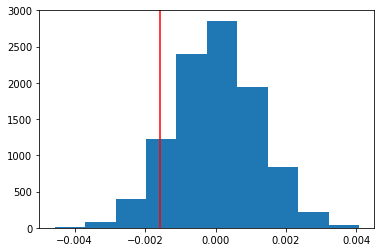

In [26]:
p_diffs = np.array(p_diffs)
obs_diff = obs_new-obs_old
plt.hist(p_diffs);
plt.axvline(x=obs_diff,color='red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
p_value = (p_diffs > obs_diff).mean()
print("The proportion that p_diffs are greater than the actual difference observed in dataset is {}.".format(p_value))

The proportion that p_diffs are greater than the actual difference observed in dataset is 0.9093.


k. What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The proportion of $P_{diffs}$ is greater than the actual observation difference is called $P_{value}$. The interpretation of this $P_{value}$ is when holding the null hypothesis that the $P_{new} - P_{old}$ $\le$ 0 is true, there is 90.08% chance that the observed sample  is in favor of alternative hypothesis. In our hypothesis, the null is defined as the old page is as good as or better than the new page. The alternative is defined as new page is better than the old page. With a Type I Error rate 5%, this $P_{value}$ is larger than that, which means we fail to reject the null hypothesis. The conclusion is that the e-commerce company should keep the old page.**

**The above procedure I only perform a one-side test instead of two-sided test that this question asks. I decide to hold on my hypothesis statement in part one and perform the test as above.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' and converted == 1").converted.sum()
convert_new = df2.query("landing_page == 'new_page' and converted == 1").converted.sum()

m. Now use `stats.proportions_ztest` to compute the test statistic and p-value.  

In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old],[n_new, n_old],alternative='larger')
print("The z_score is {} and p_value is {}.".format('%.4f' % z_score,'%.4f' % p_value))

The z_score is -1.3109 and p_value is 0.9051.


n. What do the z-score and p-value computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The $Z_{score}$ gives a probability of 0.9051, according to the Z-table we can get the $P_{value}$ is 0.9051. This $P_{value}$ is larger than given Type I Error 5% same as before. Using this large $P_{value}$, again we fail to reject the null hypothesis. So the conversion rates $P_{new} < P_{old}$. That means the old page is better than the new one, so the e-commerce company should keep the old page.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, the result I achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should be performing in this case?

**A Logistic Regression might be a good performance here.**

b. The goal is to use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, I first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate regression model on the two columns created in part b., then fit the model using the two columns created in part **b.** to predict whether or not an individual converts. 

In [31]:
df2.timestamp.max(),df2.timestamp.min()

('2017-01-24 13:41:54.460509', '2017-01-02 13:42:05.378582')

In [32]:
logit = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=logit.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of the model below, and use it as necessary to answer the following questions.

In [33]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Jun 2019   Pseudo R-squ.:               8.077e-06
Time:                        20:52:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value found in **Part II**?


**$P_{value}$ associated with ab_page is 0.190. This suggests that there is a no significant difference in conversion based on which page a customer recieves. Here our null hypothesis is there is no difference in conversion based on new page and old page, which is $P_{new}$ = $P_{old}$. Our alternative hypothesis is there is a difference in conversion of new page and old page, which is $P_{new}$ $\neq$ $P_{old}$. Since p_value here is larger than Type I Error 5%, we fail to reject the null. Conclusion is there is no difference in conversion between old page and new page. The company should keep the old page, same as conclusion in Part II.**


f. Now, considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into my regression model.  Are there any disadvantages to adding additional terms into this regression model?

**Other factor that influence an individual converts or not including the time spending on the page (the timestamp variable). Such that if there is a certain time period of the day that an individual will convert. Or consider what is the average spending time on the page could result in a high probability of converting.**

**Adding more factors to this regression model will yeild complexity. As we also need to find out the dependency of multiple explanatory variables. That makes the interpretations more difficult and hence lacks of accuracy on prediction.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. I will need to read in the **countries.csv** dataset and merge together the datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Create dummy variables for these country columns.

In [34]:
df_countries = pd.read_csv('countries.csv')
df3 = df_countries.set_index('user_id').join(df2.set_index('user_id'),how='inner')
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [35]:
# Check the categories of country.
df3.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [36]:
# Create columns for catergories of country.
df3[['us','uk','ca']]=pd.get_dummies(df3['country'])
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,us,uk,ca
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [37]:
logmo1 = sm.Logit(df3['converted'],df3[['intercept','uk','ca']])
logmo1.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Mon, 24 Jun 2019   Pseudo R-squ.:               1.521e-05
Time:                        20:52:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
uk             0.0507      0.028      1.786      0.074      -0.005       0.106
ca             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**The $P_{value}$s for countries are larger than Type I Error 5% which suggests that country is not statistically significant predicting converting.**

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and conclusions based on the results.

In [38]:
# Create columns of interactions between page and country
df3['us_page'] = df3['us']*df3['ab_page']
df3['uk_page'] = df3['uk']*df3['ab_page']
df3['ca_page'] = df3['ca']*df3['ab_page']
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,us,uk,ca,us_page,uk_page,ca_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,0,1,0


In [39]:
logmo2 = sm.Logit(df3['converted'],df3[['intercept','uk','ca','uk_page','ca_page','ab_page']])
logmo2.fit().summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 24 Jun 2019   Pseudo R-squ.:               3.482e-05
Time:                        20:52:29   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
uk             0.0118      0.040      0.296      0.767      -0.066       0.090
ca             0.0175      0.038      0.465      0.642      -0.056       0.091
uk_page        0.0783      0.057      1.378      0.168      -0.033       0.190
ca_page        0.0469      0.054      0.872      0.383      -0.059       0.152
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
==============================================================================
"""

**All the $P_{value}$s are larger than Type I Error 5% which suggests that country, page version, interactions between page and country are not statistically significant to predict if an individual is converting.**

## Conclusion

1. The limitation for above analysis is the timestamp is not being considered as a factor when predicting converstion rate. For addtional testing, we could conduct multilinear regression including quantitative variable like timestamp, along with categorical variables like countries and ab_page to predict the response variable - if an individual converting or not.
2. For a simple probability comparison, the new page conversion rate is slightly lower than the old page conversion rate. 
3. With experimenting on A/B Test, $P_{value}$s we computed using sampling distribution and built-in Z-test are both larger than Type I Error, 5%. So we fail to reject the null hypothesis. The conclusion is the e-commerce company should keep the old page.
4. After conducting regression approach, we found out that page version, country and their interaction are not statistically significant to predict wether or not an individual is converting. Further considerations could be discussed when consider timestamp variable.